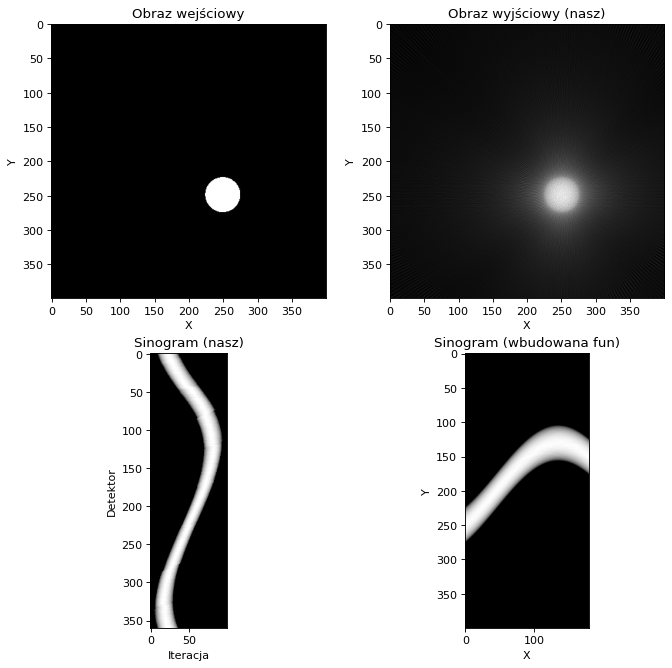

In [18]:
from skimage import io
from matplotlib import pylab as plt
import numpy as np

# input parameters
alfa = 1
detectors = 100
phi = 90

# other parameters
theta = 360.
images = ['Kolo.jpg', 'Kropka.jpg', 'Kwadraty2.jpg', 'Paski2.jpg', 'Shepp_logan.jpg', 'SADDLE_PE.JPG', 'CT_ScoutView.jpg']
image = io.imread('tomograf-zdjecia/' + images[1], as_gray = True)
    
def getEmitterPosition(angle): 
    angle_rad = np.deg2rad(angle)
    r = max(image.shape) * np.sqrt(2) / 2 
    center = max(image.shape) / 2
    x = int(r * np.cos(angle_rad) + center) 
    y = int(r * np.sin(angle_rad) + center)
    
    return x, y

def getDetectorsPositions(angle): 
    angle_rad = np.deg2rad(angle)
    phi_rad = np.deg2rad(phi)
    positions = []
    r = max(image.shape) * np.sqrt(2) / 2 
    center = max(image.shape) / 2
    
    for i in range(detectors):
        x = int(r * np.cos(angle_rad + np.pi - phi_rad / 2 + i * (phi_rad / (detectors - 1))) + center) 
        y = int(r * np.sin(angle_rad + np.pi - phi_rad / 2 + i * (phi_rad / (detectors - 1))) + center)
        positions.append([x, y])
    
    return positions

def applyBresenhamAlgorithm(x0, y0, x1, y1): 
    delta_x = x1 - x0
    delta_y = y1 - y0     
    x_direction = 1
    y_direction = 1
    line = []
    
    if delta_x < 0:
        delta_x, x_direction = abs(delta_x), -1     
                                                       
    if delta_y < 0:
        delta_y, y_direction = abs(delta_y), -1    
    
    error = delta_y - delta_x 
    y = y0 
    x = x0 
        
    if delta_x > delta_y:
        for _ in range(delta_x):
            line.append([x, y])
            if error >= 0:
                y += y_direction
                error -= delta_x
            x += x_direction
            error += delta_y
    else:
        for _ in range(delta_y):
            line.append([x, y])
            if error >= 0:
                x += x_direction
                error -= delta_y
            y += y_direction
            error += delta_x
    
    return line

def isCorrectPoint(x, y):
    if x >= 0 and y >= 0 and x < image.shape[0] and y < image.shape[1]:
        return True
    else:
        return False

def normalize1D(array):
    max_value = max(array)
    array_normalized = [value / max_value for value in array]
    
    return array_normalized
    
def normalize2D(array):
    max_value = np.amax(array)
    array_normalized = [value / max_value for value in array]
    
    return array_normalized    
    
def applyRadonTransform():    
    sinogram = []
    angles = np.linspace(0., theta, int(theta / alfa), endpoint=False)
    
    for angle in angles:
        em_pos = getEmitterPosition(angle)
        det_pos = getDetectorsPositions(angle)
        detectors_output = []
        
        for det in det_pos:
            pixels_sum = 0
            line = applyBresenhamAlgorithm(em_pos[0], em_pos[1], det[0], det[1])
            
            for point in line:
                if isCorrectPoint(point[0], point[1]):
                    pixels_sum += image[point[0], point[1]]         
                                                                    
            detectors_output.append(pixels_sum)
        
        #sinogram.append(detectors_output)
        sinogram.append(normalize1D(detectors_output))   # normalizacja tu 1D czy na koniec 2D?
           
    return sinogram

def applyInverseRadonTransform(sinogram):           
    output = np.zeros((image.shape[0], image.shape[1]), dtype=image.dtype)
    angles = np.linspace(0., theta, int(theta / alfa), endpoint=False)
    
    for i, angle in enumerate(angles):
        em_pos = getEmitterPosition(angle)
        det_pos = getDetectorsPositions(angle)
        
        for j, det in enumerate(det_pos):
            line = applyBresenhamAlgorithm(em_pos[0], em_pos[1], det[0], det[1])
            pixels_sum = sinogram[i][j]
            
            for point in line:                 
                if isCorrectPoint(point[0], point[1]):
                    output[point[0], point[1]] += pixels_sum     
    
    # output = normalize2D(output)              # poprawić normalizację
        
    return output

def main():
    sinogram = np.array(applyRadonTransform())
    output = applyInverseRadonTransform(sinogram)
    sinogram2 = transform.radon(image)
    
    fig = plt.figure(figsize=(10, 10), dpi=80)   
    ax = fig.add_subplot(221)
    ax.set_title('Obraz wejściowy')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.imshow(image, cmap = 'gray')
    
    ax = fig.add_subplot(222)
    ax.set_title('Obraz wyjściowy (nasz)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.imshow(output, cmap = 'gray')
    
    ax = fig.add_subplot(223)
    ax.set_title('Sinogram (nasz)')
    ax.set_ylabel('Iteracja')      # kąt = iteracja * alfa
    ax.set_xlabel('Detektor')
    ax.imshow(sinogram, cmap = 'gray')
    
    ax = fig.add_subplot(224)
    ax.set_title('Sinogram (wbudowana fun)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.imshow(sinogram2, cmap = 'gray')

if __name__ == '__main__':
    main()